In [76]:
import networkx as nx
import pandas as pd
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import time

class CommunityDetectionStagnant(Exception):
    pass

class CommunityDetection:
    """
        Community detection through the Louvain method.
    """
    def __init__(self, G, *, seed=None):
        self.G = G
        self.community_mapping = {i: i for i in G.nodes()}
        self.edges = nx.to_dict_of_dicts(G)
        self.communities = None
        self.random = np.random.default_rng(seed)

    def calc(self):
        self.communities = defaultdict(lambda: [0, 0])
        for edge in self.G.edges():
            c0, c1 = self.community_mapping[edge[0]], self.community_mapping[edge[1]]
            if c0 == c1:
                self.communities[c0][0] += 1
            else:
                self.communities[c0][1] += 1
                self.communities[c1][1] += 1
        
        if not self.local_maximation():
            raise CommunityDetectionStagnant('No change occured during the algorithm.')

        new_graph = nx.Graph()
        remapping = {}
        for node in self.G.nodes():
            if self.community_mapping[node] not in remapping:
                remapping[self.community_mapping[node]] = len(remapping)
            self.community_mapping[node] = remapping[self.community_mapping[node]]
        
        for edge in self.G.edges():
            new_graph.add_edge(self.community_mapping[edge[0]], self.community_mapping[edge[1]])

        try:
            new_mapping = CommunityDetection(new_graph, seed=round(self.random.random()*1e6)).calc()
            nx.draw(new_graph, node_color=[new_mapping[i] for i in new_graph.nodes()])
            for node in self.G.nodes():
                self.community_mapping[node] = new_mapping[self.community_mapping[node]]
        except CommunityDetectionStagnant:
            pass

        return list(self.community_mapping.values())

    def local_maximation(self):   
        any_change_occured = False
        while True:
            change_occured = False
            current_order = list(self.G.nodes())
            self.random.shuffle(current_order)
            for node in current_order:
                best = (None, 0)
                for neighbor in self.G.neighbors(node):
                    if self.community_mapping[node] != self.community_mapping[neighbor]:
                        mod = self.modularity(node, self.community_mapping[neighbor])
                        if mod > best[1]:
                            best = (self.community_mapping[neighbor], mod)
                if best[0] is not None:
                    self.move(node, best[0])
                    change_occured = True
                    any_change_occured = True
            if not change_occured:
                break
        return any_change_occured 

    def move(self, node, moveTo):
        moveFrom = self.community_mapping[node]
        con_from, con_to, con_out = 0, 0, 0
        for edge in self.G.neighbors(node):
            if self.community_mapping[edge] == moveTo:
                con_to += 1
            elif self.community_mapping[edge] == moveFrom:
                con_from += 1
            else:
                con_out += 1

        self.communities[moveFrom][0] -= con_from
        self.communities[moveFrom][1] += con_from
        self.communities[moveFrom][1] -= con_to
        self.communities[moveFrom][1] -= con_out
        self.communities[moveTo][0] += con_to
        self.communities[moveTo][1] -= con_to
        self.communities[moveTo][1] += con_from
        self.communities[moveTo][1] += con_out
        self.community_mapping[node] = moveTo
        

    def modularity(self, node, moveTo):
        source = self.community_mapping[node]
        base = self.total_modularity()
        self.move(node, moveTo)
        new = self.total_modularity()
        self.move(node, source)
        return new - base
                
    def total_modularity(self):
        Tin = np.sum([c[0] for c in self.communities.values()])
        Ttot = np.sum([c[0] + c[1] for c in self.communities.values()])
        m = len(self.edges)
        return Tin / 2 / m - (Ttot / 2 / m) ** 2
    
class NonGreedyCommunityDetection(CommunityDetection):
    """
        Community detection through a non-greedy Louvain method.
    """
    def local_maximation(self):
        any_change_occured = False
        while True:
            best = (None, None, 0)
            current_order = list(self.G.nodes())
            self.random.shuffle(current_order)
            for node in current_order:
                for neighbor in self.G.neighbors(node):
                    if self.community_mapping[node] != self.community_mapping[neighbor]:
                        mod = self.modularity(node, self.community_mapping[neighbor])
                        if mod > best[2]:
                            best = (node, self.community_mapping[neighbor], mod)
            if best[0] is not None:
                self.move(best[0], best[1])
                any_change_occured = True
            else:
                break
        return any_change_occured

raccoon


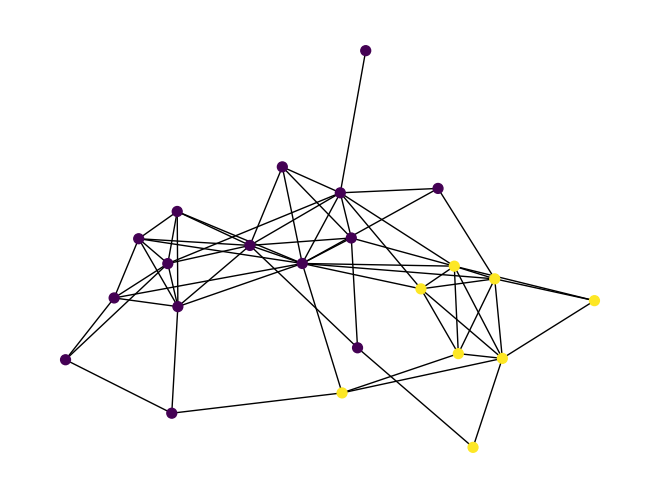

dublin


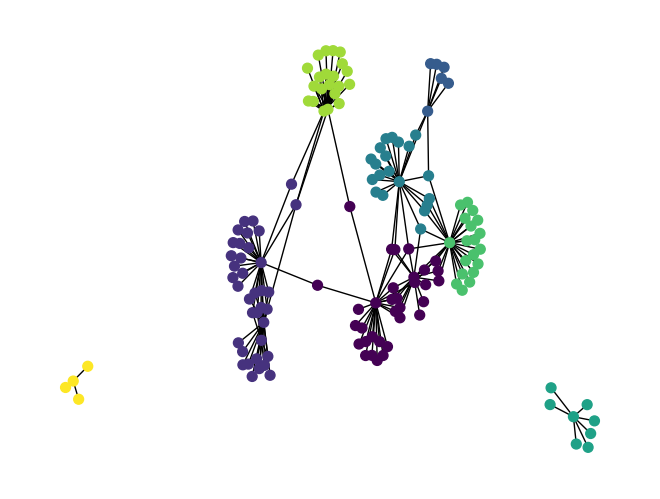

citations


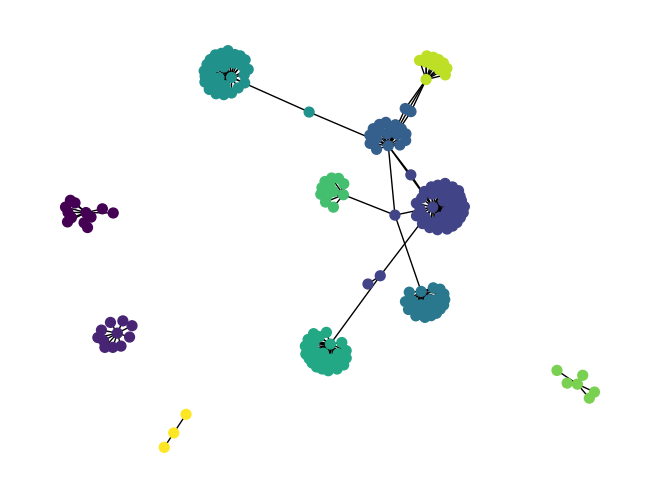

In [77]:
def load_graph(file, nrows=200):
    filenames = {
        'raccoon': 'data/mammalia-raccoon-proximity-1.edges',
        'dolphins': 'data/mammalia-dolphin-florida-forage.edges',
        'dublin': 'data/infect-dublin.edges',
        'citations': 'data/cit-DBLP.edges'
    }

    df = pd.read_csv(filenames[file], delim_whitespace=True, header=None, comment='%', nrows=nrows)
    if df.shape[1] == 1:
        df = pd.read_csv(filenames[file], delimiter=',', header=None, comment='%', nrows=nrows)
    if df.shape[1] == 2:
        df[2] = 0
    df.columns = ['source', 'target', 'weight']
    G = nx.from_pandas_edgelist(df)
    return G

        
def visualize(file, *, seed=None):
    graph = load_graph(file)
    print(file)
    nx.draw(graph, node_size=50, node_color=CommunityDetection(graph, seed=seed).calc())
    plt.show()

visualize('raccoon', seed=42)
visualize('dublin', seed=42)
visualize('citations', seed=42)

Custom implementation - Greedy (25 communities, 0.08s)


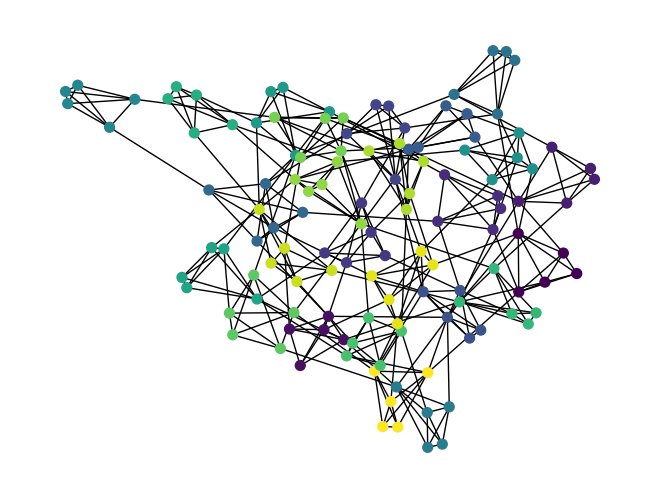

Custom implementation - Non-greedy (20 communities, 3.82s)


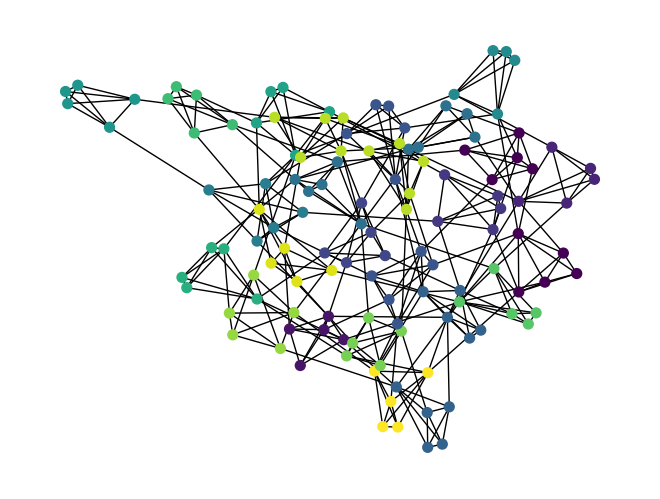

Networkx implementation (16 communities, 0.01s)


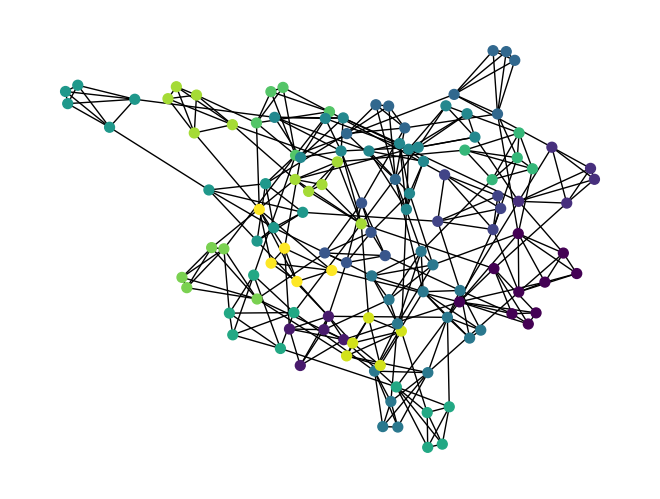

In [78]:
def visualize(file, *, seed=None):
    def normalize_community_number(communities):
        communities = sorted(communities, key=lambda x: min(x))
        community_map = {}
        for i, c in enumerate(communities):
            for node in c:
                community_map[node] = i
        return [community_map[i] for i in graph.nodes()]
    
    adjacency_matrix = np.genfromtxt(f"data/{file}.csv", delimiter=",")
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    graph = nx.Graph()
    graph.add_edges_from(edges)
    layout = nx.spring_layout(graph)

    for model, label in zip([CommunityDetection, NonGreedyCommunityDetection], ['Greedy', 'Non-greedy']):
        start = time.time()
        communities = model(graph, seed=seed).calc()
        end = time.time()
        combined = defaultdict(set)
        for node, community in zip(graph.nodes(), communities):
            combined[community].add(node)
        combined = list(combined.values())
        print(f"Custom implementation - {label} ({len(combined)} communities, {end-start:.2f}s)")
        nx.draw(graph, node_size=50, node_color=normalize_community_number(combined), pos=layout)
        plt.show()

    # compare to base method from networkx
    start = time.time()
    communities = nx.community.louvain_communities(graph, seed=seed)
    end = time.time()
    print(f"Networkx implementation ({len(communities)} communities, {end-start:.2f}s)")
    nx.draw(graph, node_size=50, node_color=normalize_community_number(communities), pos=layout)
    plt.show()

visualize('D1-UNC', seed=42)

In [86]:
def process_file(filename, community_check=None):
    adjacency_matrix = np.genfromtxt(f"data/{filename}.csv", delimiter=",")
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    graph = nx.Graph()
    graph.add_edges_from(edges)
    
    start = time.time()
    communities = CommunityDetection(graph, seed=42).calc()
    end = time.time()
    print(f"{filename}: {end-start}s", f"{np.max(communities)+1}/{community_check} communities found" if community_check is not None else "")

    with open(f"results/{filename}.csv", "w") as f:
        f.write("\n".join([f"{i+1}, {communities[i]}" for i in range(len(communities))]))


process_file('D1-UNC')
process_file('D2-UNC')
process_file('D3-UNC')
process_file('D1-K=2', 2)
process_file('D2-K=7', 7)
process_file('D3-K=12', 12)

D1-UNC: 0.08434891700744629s 
D2-UNC: 0.2741734981536865s 
D3-UNC: 0.09938335418701172s 
D1-K=2: 0.011168241500854492s 3/2 communities found
D2-K=7: 0.03082418441772461s 6/7 communities found
D3-K=12: 0.17054510116577148s 9/12 communities found
